In [21]:
import os
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [22]:
my_region = boto3.session.Session().region_name
my_region

'eu-west-1'

In [23]:
xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")
print(f"""Success - the MySageMakerInstance is in the {my_region}. 
      You will use the {xgboost_container} container for your SageMaker endpoint.
      """)

Success - the MySageMakerInstance is in the eu-west-1. 
      You will use the 685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.
      


In [24]:
try:
    urllib.request.urlretrieve ("https://d1.awsstatic.com/tmt/build-train-deploy-machine-learning-model-sagemaker/bank_clean.27f01fbbdf43271788427f3682996ae29ceca05d.csv", "bank_clean.csv")
    print('Success: downloaded bank_clean.csv.')
except Exception as e:
    print('Data load error: ',e)

try:
    model_data = pd.read_csv('./bank_clean.csv',index_col=0)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: downloaded bank_clean.csv.
Success: Data loaded into dataframe.


In [25]:
model_data.head()

,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,1,999,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
1,57,1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
2,37,1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
3,40,1,999,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
4,56,1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0


In [60]:
model_data.shape

(41188, 61)

In [26]:
train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
print(train_data.shape, test_data.shape)

(28831, 61) (12357, 61)


In [27]:
s3 = boto3.resource('s3')
bucket_name = 'godelsagemaker'
prefix = 'sagemaker/DEMO-xgboost-dm'


pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
s3.Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [28]:
X_train = train_data.drop(['y_no', 'y_yes'], axis=1)
X_test = test_data.drop(['y_no', 'y_yes'], axis=1)
y_train = train_data['y_yes']
y_test = test_data['y_yes']

## Local Implementation

In [29]:
# fit model no training data
model = XGBClassifier(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    silent=0,
    objective='binary:logistic',
    num_round=100)
model.fit(X_train, y_train)

[06:49:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1660208814268/work/src/learner.cc:627: 
Parameters: { "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.2,
              eval_metric=None, gamma=4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=6,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, num_round=100, predictor='auto',
              random_state=0, ...)

In [30]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [31]:
# evaluate predictions
#  F1 score reaches its best value at 1 and worst score at 0.
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     10936
           1       0.62      0.20      0.30      1421

    accuracy                           0.89     12357
   macro avg       0.76      0.59      0.62     12357
weighted avg       0.87      0.89      0.87     12357



In [32]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'eta' : [0.2, 0.4, 0.6, 0.8],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10]
        }
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=-1, verbosity = 0)

In [33]:
folds = 5
param_comb = 6

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params,
                                   n_iter=param_comb, scoring='recall',
                                   n_jobs=-1, cv=skf.split(X_train, y_train), verbose=5,
                                   random_state=1001)

In [34]:
%%time
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END colsample_bytree=0.8, eta=0.6, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.220 total time=  37.7s
[CV 2/5] END colsample_bytree=0.8, eta=0.6, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.238 total time=  37.8s
[CV 3/5] END colsample_bytree=0.8, eta=0.6, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.217 total time=  38.1s
[CV 4/5] END colsample_bytree=0.8, eta=0.6, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.188 total time=  38.3s
[CV 5/5] END colsample_bytree=0.8, eta=0.6, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.224 total time=  37.9s
[CV 1/5] END colsample_bytree=0.6, eta=0.4, gamma=1.5, max_depth=10, min_child_weight=10, subsample=0.8;, score=0.227 total time= 1.0min
[CV 2/5] END colsample_bytree=0.6, eta=0.4, gamma=1.5, max_depth=10, min_child_weight=10, subsample=0.8;, score=0.241 total time= 1.0

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f46bb9aa660>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_c...
                                           n_estimators=600, n_jobs=None,
                                           nthread=-1, num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, ...),
                   n_iter=6, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'eta': [0.2, 0.4, 0.6, 0.8],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5, 10],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, scoring='recall', verbose=5)

In [35]:
pd.DataFrame(random_search.cv_results_).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_min_child_weight,param_max_depth,param_gamma,param_eta,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,70.684838,8.331947,0.216588,0.032059,0.8,10,10,0.5,0.8,0.8,"{'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 10, 'gamma': 0.5, 'eta': 0.8, 'colsample_bytree': 0.8}",0.229814,0.237947,0.220497,0.215839,0.253106,0.231440,0.013248,1
1,60.157364,0.168886,0.255738,0.002981,0.8,10,10,1.5,0.4,0.6,"{'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 10, 'gamma': 1.5, 'eta': 0.4, 'colsample_bytree': 0.6}",0.226708,0.241058,0.209627,0.208075,0.234472,0.223988,0.013177,2
0,37.841892,0.227349,0.115190,0.002068,0.8,10,5,2,0.6,0.8,"{'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 5, 'gamma': 2, 'eta': 0.6, 'colsample_bytree': 0.8}",0.220497,0.237947,0.217391,0.187888,0.223602,0.217465,0.016378,3
3,37.110165,0.268751,0.088137,0.001308,0.8,10,4,0.5,0.8,1.0,"{'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'eta': 0.8, 'colsample_bytree': 1.0}",0.220497,0.236392,0.218944,0.183230,0.220497,0.215912,0.017543,4
2,21.631614,0.135731,0.086144,0.001815,1.0,1,4,1,0.4,0.6,"{'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 1, 'eta': 0.4, 'colsample_bytree': 0.6}",0.212733,0.231726,0.209627,0.178571,0.212733,0.209078,0.017150,5
4,24.816256,0.093348,0.067515,0.000681,1.0,10,3,1,0.8,1.0,"{'subsample': 1.0, 'min_child_weight': 10, 'max_depth': 3, 'gamma': 1, 'eta': 0.8, 'colsample_bytree': 1.0}",0.211180,0.208398,0.208075,0.175466,0.197205,0.200065,0.013194,6


In [36]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False, eta=0.8,
              eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=10,
              missing=nan, monotone_constraints='()', n_estimators=600,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, ...)

In [37]:
random_search.best_params_

{'subsample': 0.8,
 'min_child_weight': 10,
 'max_depth': 10,
 'gamma': 0.5,
 'eta': 0.8,
 'colsample_bytree': 0.8}

In [38]:
y_pred = random_search.best_estimator_.predict(X_test)
predictions = [round(value) for value in y_pred]
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     10936
           1       0.63      0.22      0.32      1421

    accuracy                           0.90     12357
   macro avg       0.77      0.60      0.63     12357
weighted avg       0.87      0.90      0.87     12357



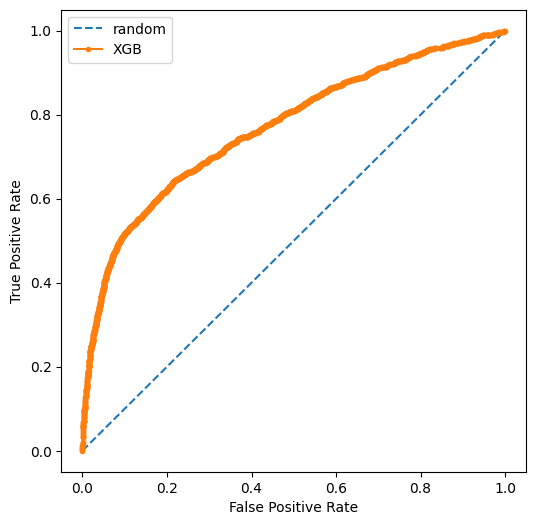

In [51]:
probas = random_search.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probas)
plt.figure(figsize=(6, 6)) 
plt.plot([0,1], [0,1], linestyle='--', label='random')
plt.plot(fpr, tpr, marker='.', label='XGB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show();

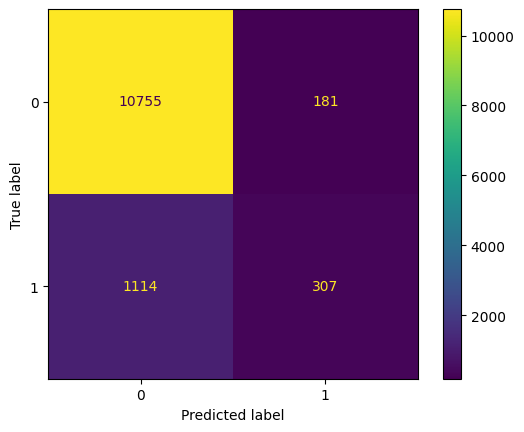

In [40]:
cm = confusion_matrix(y_test, predictions, labels=random_search.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=random_search.best_estimator_.classes_)
disp.plot()
plt.show();

## Sagemaker Implementation

In [52]:
role = os.getenv('sagemaker_role') #pass it here

sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(xgboost_container,role, instance_count=1, instance_type='ml.m4.xlarge',output_path='s3://{}/{}/output'.format(bucket_name, prefix),sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

In [53]:
xgb.fit({'train': s3_input_train})

2022-08-24 06:58:30 Starting - Starting the training job...
2022-08-24 06:58:54 Starting - Preparing the instances for trainingProfilerReport-1661324309: InProgress
.........
2022-08-24 07:00:23 Downloading - Downloading input data...
2022-08-24 07:01:03 Training - Downloading the training image..............................
2022-08-24 07:06:20 Training - Training image download completed. Training in progress..Arguments: train
[2022-08-24:07:06:26:INFO] Running standalone xgboost training.
[2022-08-24:07:06:26:INFO] Path /opt/ml/input/data/validation does not exist!
[2022-08-24:07:06:26:INFO] File size need to be processed in the node: 3.38mb. Available memory size in the node: 8839.17mb
[2022-08-24:07:06:26:INFO] Determined delimiter of CSV input is ','
[07:06:26] S3DistributionType set as FullyReplicated
[07:06:26] 28831x59 matrix with 1701029 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[07:06:26] src/tree/updater_prune.cc:74: tree pruning end,

In [54]:
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

------!

In [55]:
from sagemaker.serializers import CSVSerializer

test_data_array = test_data.drop(['y_no', 'y_yes'], axis=1).values #load the data into an array
xgb_predictor.serializer = CSVSerializer() # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

(12357,)


In [56]:
cm = pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions_array), rownames=['Observed'], colnames=['Predicted'])
tn = cm.iloc[0,0]; fn = cm.iloc[1,0]; tp = cm.iloc[1,1]; fp = cm.iloc[0,1]; p = (tp+tn)/(tp+tn+fp+fn)*100
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Rate: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "No Purchase", "Purchase"))
print("Observed")
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("No Purchase", tn/(tn+fn)*100,tn, fp/(tp+fp)*100, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("Purchase", fn/(tn+fn)*100,fn, tp/(tp+fp)*100, tp))


Overall Classification Rate: 89.5%

Predicted      No Purchase    Purchase
Observed
No Purchase    90% (10769)    37% (167)
Purchase        10% (1133)     63% (288) 



In [105]:
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

## Optimal Threshold finding

Let's assume that:
- interest for one *TN* is `Interest = Principal loan amount x Interest rate x Time (aka Number of years in term)`
- profit for one *FP* or *TP* is 0$
- loss for one *FN* is `Loss = Principal loan amount`

Let's also assume that:
- average principal loan amount = 10000 EUR
- average [interest rate = 2% ](https://www.ecb.europa.eu/press/pr/stats/mfi/html/ecb.mir2206~bb283783b8.en.html)
- time = 5 years

In [106]:
def threshold_optima(r, model, table=False, plot=False):

    thresholds = np.linspace(0.1, 0.9, 81)
    results = pd.DataFrame(columns = ["threshold", "tn", "fp", "fn", "tp", "profit", "f1_score"])
    for threshold in thresholds:
        y_new_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_new_pred).ravel()
        profit = tn * r * avg_duration * avg_amount - fn * avg_amount
        f1 = f1_score(y_test, y_new_pred)
        output = pd.Series([threshold, tn, fp, fn, tp, profit, f1], index=results.columns)
        results = results.append(output, ignore_index=True)
    idx = np.argmax(results['profit'])
    print("For interest rate %.3f optimal threshold is %.2f" % (r, thresholds[idx]))
    print("F1 - score is %.2f" % results['f1_score'][idx])
    print(f"Best profit is {results['profit'][idx]}")

    if table != False:
        return results

    if plot != False:
        plt.figure(figsize=(10,5)) 
        plt.plot(results['threshold'], results['profit'], marker='.', label='profits', color='navy')
        plt.xlabel('threshold')
        plt.ylabel('profits')
        plt.legend()
        plt.show();

For interest rate 0.020 optimal threshold is 0.15
F1 - score is 0.45
Best profit is 25628000.0


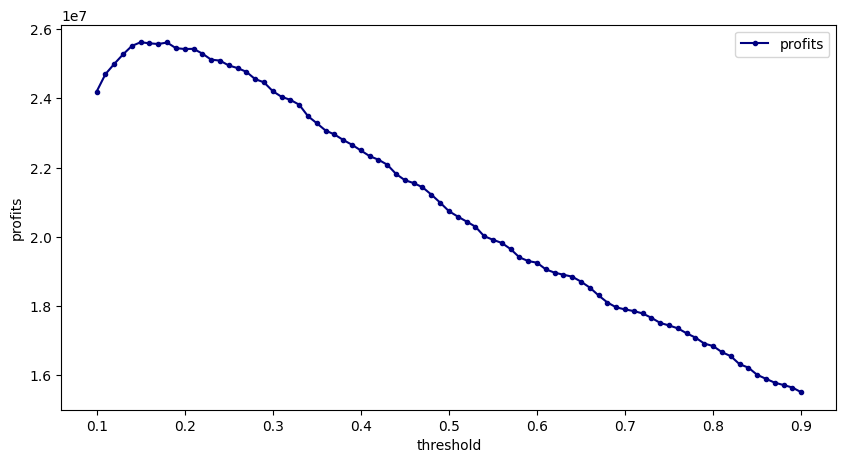

In [109]:
avg_duration = 10
avg_amount = 20000
threshold_optima(0.02, random_search.best_estimator_, False, True)

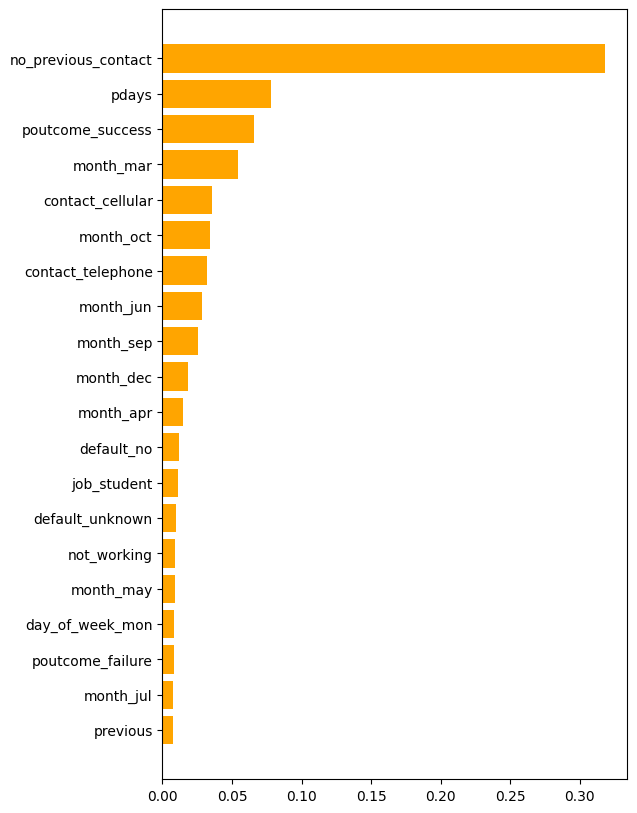

In [108]:
feature_importance = pd.DataFrame()
feature_importance['feature_name'] = model_data.columns[:-2]
feature_importance['value'] = random_search.best_estimator_.feature_importances_
feature_importance = feature_importance.sort_values(by='value', ascending=False)

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(6, 10))

ax.barh(feature_importance['feature_name'][:20], feature_importance['value'][:20], align='center', color='orange')
ax.invert_yaxis();